# End-to-End Data Cleaning Pipeline with Raha and Baran (Minimal and Sequential)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

In [64]:
from importlib import reload
import pandas
import IPython.display
from pandas import DataFrame, Series
import raha
import numpy as np
import matplotlib.pyplot as plt

## Error Detection with Raha

### 1. Instantiating the Detection Class
We first instantiate the `Detection` class.

In [2]:
app_1 = raha.Detection()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20

# Would you like to see the logs?
app_1.VERBOSE = True

### 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
    "name": "flights",
    "path": "datasets/flights/dirty.csv",
    "clean_path": "datasets/flights/clean.csv"
}
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


### 3. Running Error Detection Strategies
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. 

In [4]:
app_1.run_strategies(d)

309 strategy profiles are collected.


I just load strategies' results as they have already been run on the dataset!


### 4. Generating Features
Raha then generates a feature vector for each data cell based on the output of error detection strategies. 

In [5]:
app_1.generate_features(d)

40 Features are generated for column 0.
65 Features are generated for column 1.
62 Features are generated for column 2.
65 Features are generated for column 3.
71 Features are generated for column 4.
65 Features are generated for column 5.
86 Features are generated for column 6.


### 5. Building Clusters
Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [6]:
app_1.build_clusters(d)

A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.


### 6. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [7]:
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)
    else:
        print("Label the dirty cells in the following sampled tuple.")
        sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
        IPython.display.display(sampled_tuple)
        for j in range(d.dataframe.shape[1]):
            cell = (d.sampled_tuple, j)
            value = d.dataframe.iloc[cell]
            correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
            user_label = 1 if value != correction else 0
            d.labeled_cells[cell] = [user_label, correction]
        d.labeled_tuples[d.sampled_tuple] = 1

Tuple 35 is sampled.
Tuple 35 is labeled.
Tuple 1613 is sampled.
Tuple 1613 is labeled.
Tuple 286 is sampled.
Tuple 286 is labeled.
Tuple 667 is sampled.
Tuple 667 is labeled.
Tuple 1788 is sampled.
Tuple 1788 is labeled.
Tuple 194 is sampled.
Tuple 194 is labeled.
Tuple 1068 is sampled.
Tuple 1068 is labeled.
Tuple 1473 is sampled.
Tuple 1473 is labeled.
Tuple 2070 is sampled.
Tuple 2070 is labeled.
Tuple 1505 is sampled.
Tuple 1505 is labeled.
Tuple 59 is sampled.
Tuple 59 is labeled.
Tuple 212 is sampled.
Tuple 212 is labeled.
Tuple 1042 is sampled.
Tuple 1042 is labeled.
Tuple 1642 is sampled.
Tuple 1642 is labeled.
Tuple 1939 is sampled.
Tuple 1939 is labeled.
Tuple 1611 is sampled.
Tuple 1611 is labeled.
Tuple 2189 is sampled.
Tuple 2189 is labeled.
Tuple 1864 is sampled.
Tuple 1864 is labeled.
Tuple 1710 is sampled.
Tuple 1710 is labeled.
Tuple 1944 is sampled.
Tuple 1944 is labeled.


### 7. Propagating User Labels
Raha then propagates each user label through its cluster.

In [8]:
app_1.propagate_labels(d)

The number of labeled data cells increased from 140 to 12025.


### 8. Predicting Labels of Data Cells
Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [9]:
app_1.predict_labels(d)

A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.


### 9. Storing Results
Raha can also store the error detection results.

In [10]:
app_1.store_results(d)

The results are stored in datasets/flights/raha-baran-results-flights/error-detection/detection.dataset.


### 10. Evaluating the Error Detection Task
We can finally evaluate our error detection task.

In [11]:
p, r, f = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
print("Raha's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Raha's performance on flights:
Precision = 0.86
Recall = 0.80
F1 = 0.83


/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


# Error Correction with Baran

### 1. Instantiating the Correction Class
We first instantiate the `Correction` class.

In [12]:
app_2 = raha.Correction()

# How many tuples would you label?
app_2.LABELING_BUDGET = 20

# Would you like to see the logs?
app_2.VERBOSE = True

app_2.MIN_ALTERNATIVE_PROBABILITY = 0.45

### 2. Initializing the Dataset Object
We next initialize the dataset object.

In [13]:
d = app_2.initialize_dataset(d)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


### 3. Initializing the Error Corrector Models
Baran initializes the error corrector models.

In [14]:
app_2.initialize_models(d)

The error corrector models are initialized.


### 4. Interactive Tuple Sampling, Labeling, Model updating, Feature Generation, and Correction Prediction
Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [15]:
# while len(d.labeled_tuples) < app_2.LABELING_BUDGET:
#     app_2.sample_tuple(d)
#     if d.has_ground_truth:
#         app_2.label_with_ground_truth(d)
#     else:
#         print("Label the dirty cells in the following sampled tuple.")
#         sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
#         IPython.display.display(sampled_tuple)
#         for j in range(d.dataframe.shape[1]):
#             cell = (d.sampled_tuple, j)
#             value = d.dataframe.iloc[cell]
#             correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
#             user_label = 1 if value != correction else 0
#             d.labeled_cells[cell] = [user_label, correction]
#         d.labeled_tuples[d.sampled_tuple] = 1
#     app_2.update_models(d)
#     app_2.generate_features(d)
#     app_2.predict_corrections(d)

#labeled_tuples_list = list(d.labeled_tuples.keys())
#k = labeled_tuples_list[0]

#si = d.labeled_tuples[k]
#d.sampled_tuple = k
#app_2.update_models(d)
#app_2.generate_features(d)

for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are updated with new labeled tuple 35.
538163 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 756
    Column 4: 1656
    Column 5: 1639
    Column 6: 1164
Corrections applied in this step:
    Column 3: 876 Real changes: 876
    Column 4: 664 Real changes: 664
    Column 5: 1049 Real changes: 1049
    Column 6: 768 Real changes: 768
74% (3359 / 4536) of data errors are corrected.
The error corrector models are updated with new labeled tuple 1613.
538973 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 762
    Column 4: 1660
    Column 5: 1646
    Column 6: 1172
Corrections applied in this step:
    Column 3: 876 Real changes: 0
  

In [16]:
#d.corrected_cells = {}

In [17]:
#app_2.predict_corrections(d)

### 5. Storing Results
Baran can also store the error correction results.

In [18]:
app_2.store_results(d)

The results are stored in datasets/flights/raha-baran-results-flights/error-correction/correction.dataset.


### 6. Evaluating the Error Correction Task
We can finally evaluate our error correction task.

In [19]:
p, r, f = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]
print("Baran's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Baran's performance on flights:
Precision = 0.76
Recall = 0.59
F1 = 0.67


In [20]:
actual_errors = d.get_actual_errors_dictionary()

In [21]:
#d = pickle.load(open("datasets/flights/raha-baran-results-flights/error-correction/correction.dataset", "rb"))

In [22]:
d.dataframe.shape[0] * d.dataframe.shape[1]

16632

In [23]:
detected_cell_list = list(d.detected_cells.items())
probabilities = [detection[1] for detection in detected_cell_list]
is_correctly_detected = [cell[0] in actual_errors for cell in detected_cell_list]
p_array = np.array(probabilities)

(array([  60.,   26.,   25.,   46.,   34.,   32.,    4.,   18.,   39.,
          42.,   22.,   11.,   24.,    6.,   56.,   55.,   62.,  167.,
         101., 3705.]),
 array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
        0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
        0.95 , 0.975, 1.   ]),
 <BarContainer object of 20 artists>)

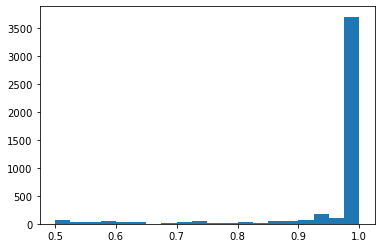

In [24]:
plt.hist(p_array[:,1], bins=np.linspace(0.5, 1.0, 21))

In [25]:
p_df = DataFrame([list(detection[0]) + list(detection[1]) for detection in detected_cell_list], columns=["row", "column", "p_not", "p"])
p_df = p_df[["row", "column", "p"]]
p_df["correct"] = is_correctly_detected

correct
False    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
True     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

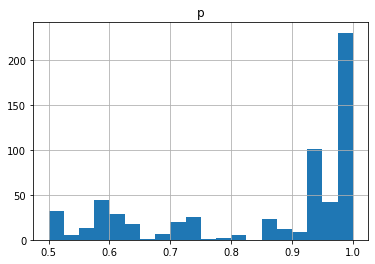

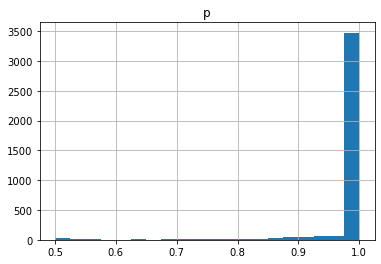

In [26]:
p_df[["correct","p"]].groupby("correct").hist(bins=np.linspace(0.5, 1.0, 21))

In [27]:
undetected_cell_list = list(d.undetected_cells.items())
probabilities = [detection[1] for detection in undetected_cell_list]
is_correctly_detected = [cell[0] not in actual_errors for cell in undetected_cell_list]

p_df_n = DataFrame([list(detection[0]) + list(detection[1]) for detection in undetected_cell_list], columns=["row", "column", "p_not", "p"])
p_df_n = p_df_n[["row", "column", "p"]]
p_df_n["correct"] = is_correctly_detected

correct
False    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
True     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

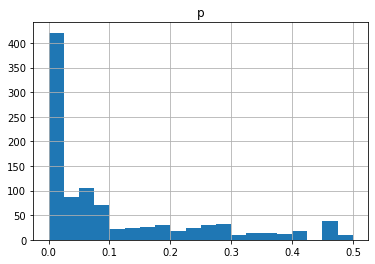

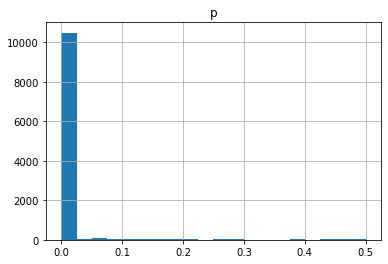

In [28]:
p_df_n[["correct","p"]].groupby("correct").hist(bins=np.linspace(0.0, 0.5, 21))

In [29]:
low_p = p_df[p_df["p"] < 0.60]

In [30]:
low_p.shape[0]

158

In [31]:
p_df.shape[0]

4536

In [32]:
low_p_dataframe = d.dataframe.loc[low_p["row"].unique(),:]

In [33]:
sum(d.extended_labeled_cells.values())

3195

Histograms of the probabilities of the detection algorithm by (label, true label)


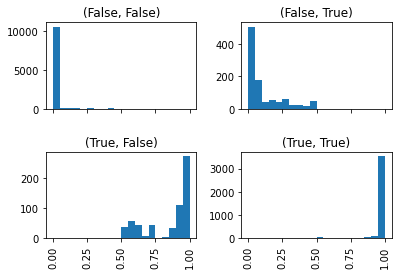

In [34]:
from raha import analysis_utilities
analysis_utilities.detection_evaluation(d,actual_errors)

In [35]:
correction_features = []

for cell in d.corrected_cells:
    correction_features.append(list(cell) +
                               [d.dataframe.iloc[cell]] +
                               [d.corrected_cells[cell]] +
                               [actual_errors[cell] if cell in actual_errors else d.dataframe.iloc[cell]] +
                               list(d.pair_features[cell][d.corrected_cells[cell]]))

In [36]:
correction_features_df = DataFrame(correction_features,
                                   columns=["row",
                                            "column",
                                            "old_value",
                                            "new_value",
                                            "actual_value",
                                            *[f"feature_value_{i}" for i in range(8)],
                                            *[f"feature_vicinity_{i}" for i in range(7)],
                                            "feature_domain"])

In [37]:
correction_features_df.iloc[:,5:].mean().sort_values()

feature_value_0       0.002081
feature_vicinity_1    0.003178
feature_value_2       0.003232
feature_value_3       0.003232
feature_value_1       0.009103
feature_value_5       0.009749
feature_domain        0.009888
feature_vicinity_0    0.011443
feature_value_7       0.014562
feature_value_4       0.019831
feature_value_6       0.031841
feature_vicinity_5    0.168643
feature_vicinity_4    0.180750
feature_vicinity_6    0.196870
feature_vicinity_3    0.257959
feature_vicinity_2    0.906096
dtype: float64

In [38]:
correction_features_df.iloc[:,[1] + list(range(5,correction_features_df.shape[1]))].groupby("column").mean()

,feature_value_0,feature_value_1,feature_value_2,feature_value_3,feature_value_4,feature_value_5,feature_value_6,feature_value_7,feature_vicinity_0,feature_vicinity_1,feature_vicinity_2,feature_vicinity_3,feature_vicinity_4,feature_vicinity_5,feature_vicinity_6,feature_domain
column,,,,,,,,,,,,,,,,
3,0.001130,0.006780,0.005085,0.005085,0.000000,0.000000,0.012147,0.007815,0.010169,0.005530,0.990729,0.000000,0.319062,0.042161,0.363730,0.015170
4,0.000000,0.000000,0.000944,0.000944,0.050051,0.018445,0.052011,0.015872,0.012195,0.002997,0.817284,0.407556,0.000000,0.270368,0.174126,0.008020
5,0.006475,0.024977,0.005154,0.005154,0.001850,0.007216,0.017411,0.015967,0.010176,0.001066,0.904671,0.178944,0.188534,0.000000,0.243962,0.007403
6,0.000000,0.002235,0.001596,0.001596,0.027933,0.012886,0.046568,0.018094,0.013408,0.003603,0.921775,0.443999,0.233304,0.385561,0.000000,0.009720


In [39]:
correction_features_df["wrong_correction"] = (correction_features_df["old_value"] == correction_features_df["actual_value"]) & (correction_features_df["old_value"] != correction_features_df["new_value"])

In [40]:
correction_features_df["wrong_correction"].sum() / correction_features_df.shape[0]

0.08894668400520156

In [41]:
distinct_features = []

for column_index in range(d.dataframe.shape[1]):
    unique_rows = np.unique(d.column_features[column_index], axis=0)
    distinct_features.append(unique_rows.shape[0])

distinct_features

[1390, 114, 308, 288, 514, 393, 525]

In [42]:
cluster_features = []

for cluster_i in range(1,21):
    cluster_features.append(d.column_features[3][
        [key[0] for key in d.clusters_k_j_c_ce[21][3][cluster_i].keys()]])

In [43]:
cluster_feature_means = np.array([cluster.mean(axis=0) for cluster in cluster_features])

In [44]:
Series([len(cluster) for cluster in d.clusters_k_j_c_ce[21][3].values()]).value_counts().sort_index()

1      3
2      2
4      3
7      1
10     1
12     2
13     1
31     1
32     1
72     1
102    1
211    1
344    1
751    1
760    1
dtype: int64

In [45]:
from raha.analysis_utilities import explain_detection

In [46]:
explain_detection(d, (50,3))

Original Value: ''
Label: 1
Confidence: 0.9999731508343098
Cell belongs to cluster (Column 3, Cluster 2)
Total number of cells in this cluster: 760
Cell was labeled by cluster label extension with label 1
Other cells in the same cluster (sample of max 5 cells):
(2175, 3): '' Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1513, 3): '' Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(964, 3): '' Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1545, 3): '' Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [47]:
from random import sample

[(cell, d.dataframe.iloc[cell]) for cell in sample(d.detected_cells.keys(), 20)]

[((753, 3), ''),
 ((396, 3), ''),
 ((1348, 3), '11:40aDec 1'),
 ((1473, 6), '9:19 p.m. (Estimated)'),
 ((1623, 4), 'Not Available'),
 ((361, 4), '12:13 p.m.'),
 ((1705, 4), '4:35 p.m.'),
 ((698, 3), ''),
 ((93, 5), ''),
 ((1560, 6), '6:19 p.m.'),
 ((899, 3), ''),
 ((589, 4), '4:28 p.m.'),
 ((407, 4), ''),
 ((673, 4), '6:56 p.m.'),
 ((174, 5), '3:50 p.m.'),
 ((191, 4), '3:36 p.m.'),
 ((304, 6), '11:54 p.m.'),
 ((1391, 6), '8:45aDec 1'),
 ((651, 3), ''),
 ((977, 4), '1:19 p.m.')]

In [48]:
explain_detection(d, (1000, 4))

Original Value: '12:10 p.m.'
Label: 0
Confidence: 0.9003630013790888
Cell belongs to cluster (Column 4, Cluster 5)
Total number of cells in this cluster: 483
This cell is not part of a labeled cluster. It was labeled by the classification.
However, there are the following labeled cells in its cluster:
(59, 4): '10:53 a.m.' Label: 1
(1788, 4): '10:18 a.m.' Label: 0
(1864, 4): '12:13 p.m.' Label: 0
(2070, 4): '10:55 a.m.' Label: 0
(2189, 4): '12:14 p.m.' Label: 1


In [49]:
explain_detection(d, (3,4))

Original Value: '6:54 a.m.'
Label: 0
Confidence: 0.8046700242528028
Cell belongs to cluster (Column 4, Cluster 8)
Total number of cells in this cluster: 436
This cell is not part of a labeled cluster. It was labeled by the classification.
However, there are the following labeled cells in its cluster:
(35, 4): '8:51 a.m.' Label: 0
(1068, 4): '5:56 a.m.' Label: 1
(1505, 4): '7:25 a.m.' Label: 0


In [52]:
[collection for collection in d.correction_collection.items() if len(collection[1]) > 1][:10]

[((14, 4), {'2:03 p.m.': 0.5819464005465732, '2:04 p.m.': 0.6619050429798664}),
 ((47, 4),
  {'7:16 a.m.': 0.465034512639066,
   '7:39 a.m.': 0.465034512639066,
   '7:32 a.m.': 0.999994552609424}),
 ((55, 4), {'7:58 p.m.': 0.6710175220915144, '7:59 p.m.': 0.8588688445647011}),
 ((57, 4),
  {'12:37 p.m.': 0.5379362909232313, '11:32 a.m.': 0.5239766432260685}),
 ((62, 4),
  {'12:58 a.m.': 0.5379362909232313, '12:41 a.m.': 0.5239766432260685}),
 ((64, 4), {'7:56 a.m.': 0.6026949519403603, '7:29 a.m.': 0.9556874941721657}),
 ((74, 4),
  {'12:12 p.m.': 0.8007590661038395, '12:13 p.m.': 0.9621989308208898}),
 ((75, 4),
  {'12:06 p.m.': 0.7148426455419488, '11:56 a.m.': 0.9556874941721657}),
 ((78, 4), {'6:17 a.m.': 0.8588688445647011, '6:02 a.m.': 0.8080191822575356}),
 ((79, 4), {'9:01 a.m.': 0.7944566271348601, '8:40 a.m.': 0.5239766432260685})]

In [51]:
sum([len(collection) for collection in d.correction_collection.values()]) / len(d.correction_collection)

2.1618525896414345

(array([2913.,  252.,   67.,    0.,   31.,  131.,    0.,  203.,  285.,
         134.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

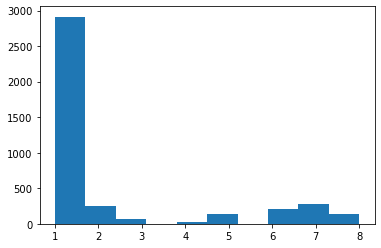

In [53]:
plt.hist([len(collection) for collection in d.correction_collection.values()])

In [65]:
reload(analysis_utilities)

from raha.analysis_utilities import alternative_corrections_overview

alternative_corrections_overview(d, (14, 4))

Correction: 2:04 p.m.
Correction confidence: 0.5977993326733696
Alternative corrections and their confidence values: {'2:03 p.m.': 0.5819464005465732, '2:04 p.m.': 0.6619050429798664}
Hint: The actual correction is included in the alternative corrections and the confidence value
in the alternative corrections can be higher. This is because of baran prefering models trained with
more examples. The alternative correction contains the maximum confidence for every repair value recorded
over the cleaning process.


In [66]:
alternative_corrections_overview(d, (55, 4))

Correction: 7:59 p.m.
Correction confidence: 0.83029365006959
Alternative corrections and their confidence values: {'7:58 p.m.': 0.6710175220915144, '7:59 p.m.': 0.8588688445647011}
Hint: The actual correction is included in the alternative corrections and the confidence value
in the alternative corrections can be higher. This is because of baran prefering models trained with
more examples. The alternative correction contains the maximum confidence for every repair value recorded
over the cleaning process.


In [51]:
df = d.correction_prediction_dfs[0][5]

AttributeError: 'Dataset' object has no attribute 'correction_prediction_dfs'

In [ ]:
df["prediction"].sum()

In [ ]:
df["prediction"].groupby(df["cell"]).sum().sort_values()

In [ ]:
df = df[df["prediction"] == 1]

In [ ]:
df["probability"].hist(bins=np.linspace(0.5, 1.0, 21))

In [ ]:
aggregated = df.groupby("cell").agg({"prediction": "sum",
                                     "cell": "first",
                                     "probability": list,
                                     "correction": list})
aggregated = aggregated[aggregated["prediction"] == 2]
aggregated

In [ ]:
# Compare correction and actual
cell = (59,5)
print(d.corrected_cells[cell])
print(actual_errors[cell])

In [ ]:
confidence_list = list(d.correction_confidences.items())
is_correctly_detected = [cell_conf_tuple[0] in actual_errors for cell_conf_tuple in confidence_list]
is_correctly_corrected = [cell_conf_tuple[0] in actual_errors and
                          d.corrected_cells[cell_conf_tuple[0]] == actual_errors[cell_conf_tuple[0]]
                          for cell_conf_tuple in confidence_list]
correction_confidence_df = DataFrame({"cell": [item[0] for item in confidence_list],
                                      "confidence": [item[1] for item in confidence_list],
                                      "detection_correct": is_correctly_detected,
                                      "correct": is_correctly_corrected})
correction_confidence_df

In [ ]:
correction_confidence_df[correction_confidence_df["detection_correct"] & ~correction_confidence_df["correct"]]

In [ ]:
f = analysis_utilities.correction_correctness_by_confidence(correction_confidence_df)
f.show()

In [ ]:
d.correction_prediction_dfs[0][3][d.correction_prediction_dfs[0][3]["prediction"] == 1]

In [ ]:
df = d.correction_prediction_dfs[15][3]
df["probability"].hist(bins=np.linspace(0.0, 1.0, 21))